In [2]:
import json
from itertools import islice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [3]:
from gluonts.dataset.artificial import recipe as rcp
from gluonts.core.serde import dump_code, load_code

In [4]:
# plotting utils

def plot_recipe(recipe, length):
    output_dict = rcp.evaluate(recipe, length)
    K = len(output_dict)
    lct = MultipleLocator(288)
    minor = AutoMinorLocator(12)

    fig, axs = plt.subplots(K, 1, figsize=(16, 2 * len(recipe)))
    for i, k in enumerate(output_dict):
        axs[i].xaxis.set_major_locator(lct)
        axs[i].xaxis.set_minor_locator(minor)
        axs[i].plot(output_dict[k])
        axs[i].grid()
        axs[i].set_ylabel(k)


def plot_examples(recipe, target, length, num, anomaly_indicator=None):
    fix, axs = plt.subplots(num, 1, figsize=(16, num * 2))
    for i in range(num):
        xx = rcp.evaluate(recipe, length)
        axs[i].plot(xx[target])
        axs[i].set_ylim(0, 1.1*np.max(xx[target]))
        axs[i].grid()
        if anomaly_indicator is not None:
            axs[i].fill_between(
                np.arange(len(xx[target])), 
                xx[anomaly_indicator] * 1.1*np.max(xx[target]), 
                np.zeros(len(xx[target])), 
                alpha=0.3,
                color="red")


def print_dicts(*dicts):
    for d in dicts:
        print("{")
        for k,v in d.items():
            print("\t", k, ": ", v)
        print("}\n")

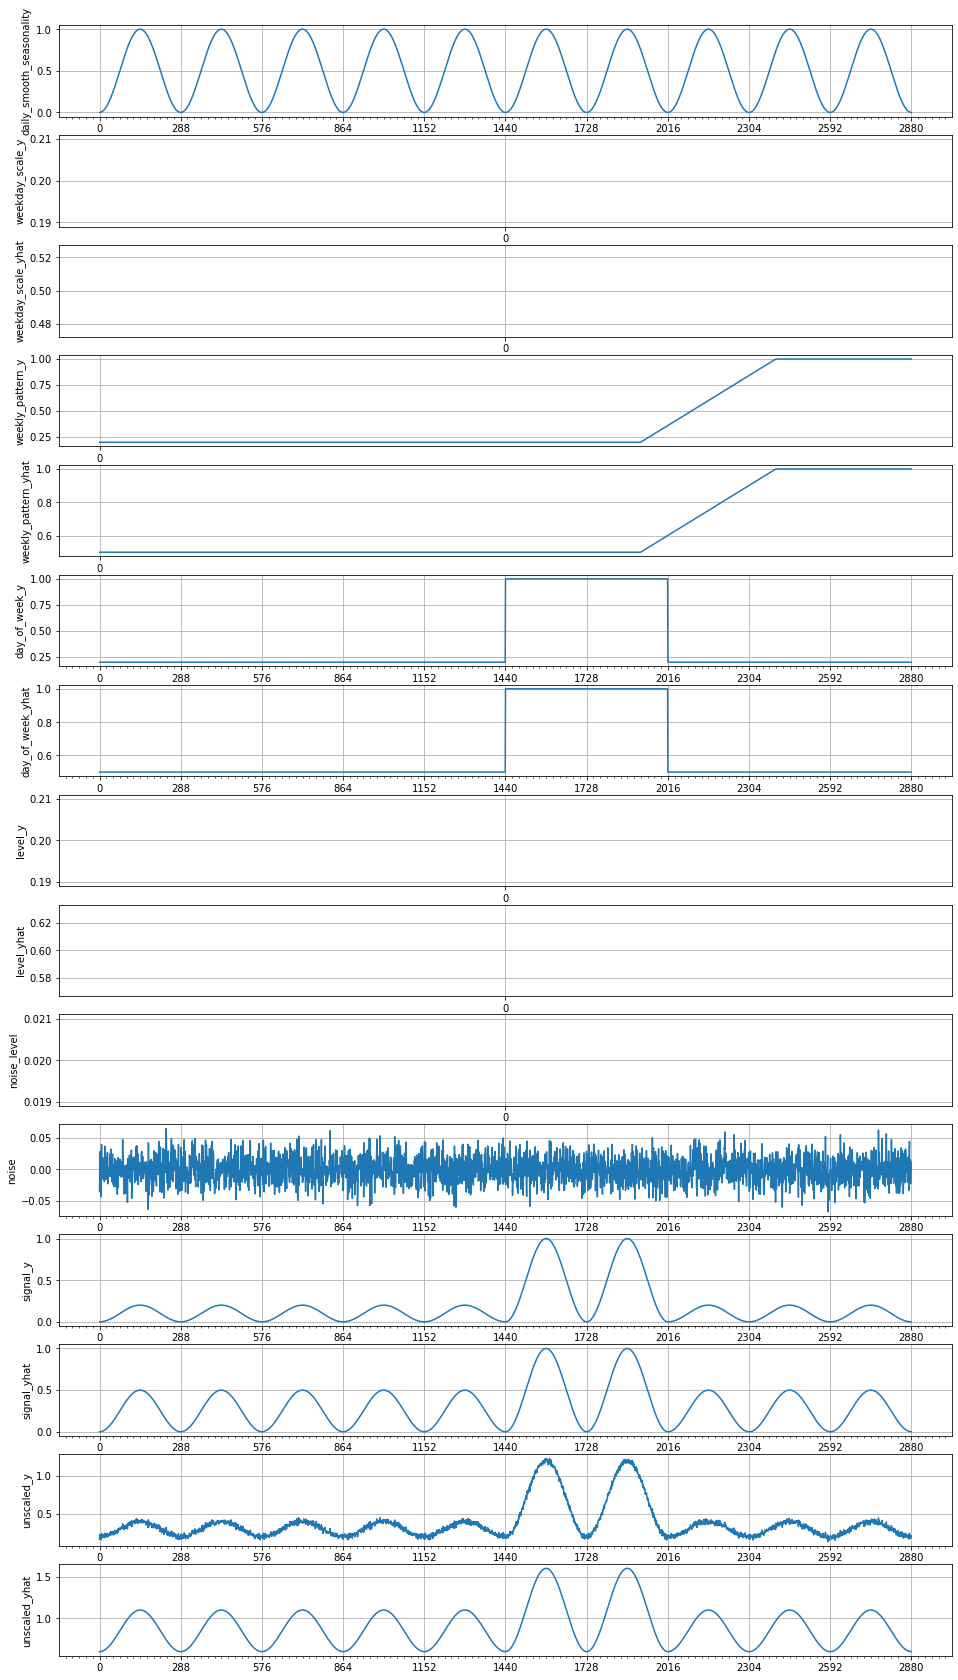

In [5]:
weekly_seasonal_unscaled = [
    ('daily_smooth_seasonality', rcp.SmoothSeasonality(period=288, phase=-72)),
    ('weekday_scale_y', np.array([0.2])),
    ('weekday_scale_yhat', np.array([0.5])),
    ('weekly_pattern_y', rcp.NormalizeMax(rcp.Concatenate([rcp.Ref("weekday_scale_y") * np.ones(5), np.ones(2)]))),
    ('weekly_pattern_yhat', rcp.NormalizeMax(rcp.Concatenate([rcp.Ref("weekday_scale_yhat") * np.ones(5), np.ones(2)]))),
    ('day_of_week_y', rcp.Dilated(rcp.Repeated('weekly_pattern_y'), 288)),
    ('day_of_week_yhat', rcp.Dilated(rcp.Repeated('weekly_pattern_yhat'), 288)),
    ('level_y', np.array([0.2])),
    ('level_yhat', np.array([0.6])),
    ('noise_level', np.array([0.02])),
    ('noise', 'noise_level' * rcp.RandomGaussian()),
    ('signal_y', rcp.Mul(['daily_smooth_seasonality','day_of_week_y'])),
    ('signal_yhat', rcp.Mul(['daily_smooth_seasonality','day_of_week_yhat'])),
    ('unscaled_y', rcp.Add(['level_y', 'signal_y', 'noise'])),
    ('unscaled_yhat', rcp.Add(['level_yhat', 'signal_yhat']))
]
     
plot_recipe(weekly_seasonal_unscaled, 10 * 288)

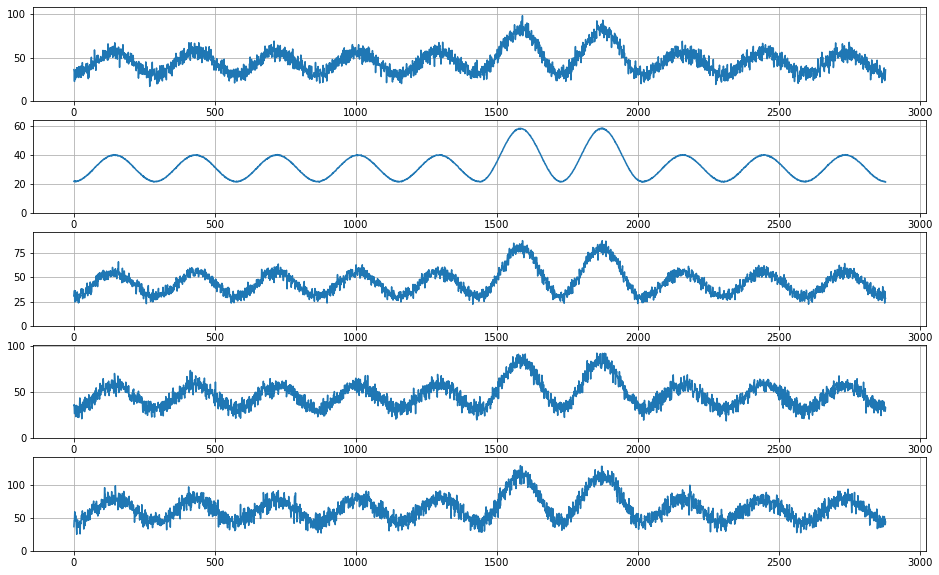

In [6]:
scaling = [
    ("scale", rcp.RandomUniform(low=0, high=100, shape=1)),
#     ("error", (rcp.Ref("scale")/10) * rcp.RandomUniform(low=-1, high=1, shape=1)),
    ("error", rcp.RandomGaussian() * rcp.RandomUniform(low=-1, high=1, shape=1)),
    ("y", rcp.Ref("scale") * rcp.Ref("unscaled_y")),
    ("yhat", rcp.Ref("scale") * rcp.Ref("unscaled_yhat")+(rcp.Ref("scale")/10)*rcp.Ref("error"))
]

weekly_seasonal = weekly_seasonal_unscaled + scaling

plot_examples(weekly_seasonal, "yhat", 10 * 288, 5)

In [7]:
num_series = 10000

synthetic_ts = rcp.take_as_list(rcp.generate(10 * 288, weekly_seasonal, "2020-01-01", {}), num_series)

In [10]:
df_l = []
for ts in synthetic_ts:
    df_l.append(pd.DataFrame({
        "ts_id": ts['item_id'],
        "scale":ts['scale'][0],
        "y": ts['y'],
        "yhat": ts['yhat']
    }))

In [11]:
# ts_df=pd.concat(df_l)

In [12]:
ts_df=pd.concat(df_l)
ts_df.to_csv("data/synthetic_ts.csv", index=False)

<AxesSubplot:ylabel='Frequency'>

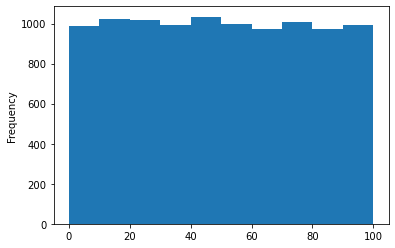

In [60]:
ts_df[['ts_id',"scale"]].drop_duplicates().scale.plot(kind='hist')rcp.RandomGaussian